## Plotting BLISS DC2 Results

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import torch
import numpy as np
from os import environ
from pathlib import Path
from einops import rearrange
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from hydra import initialize, compose
from hydra.utils import instantiate

from bliss.surveys.dc2 import DC2
from pathlib import Path

environ["BLISS_HOME"] = str(Path().resolve().parents[1])

output_dir = Path("./DC2_exp_output/")
output_dir.mkdir(parents=True, exist_ok=True)

In [18]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

### Load One Full Image

In [19]:
dc2: DC2 = instantiate(notebook_cfg.surveys.dc2)
test_sample = dc2.get_plotting_sample(0)

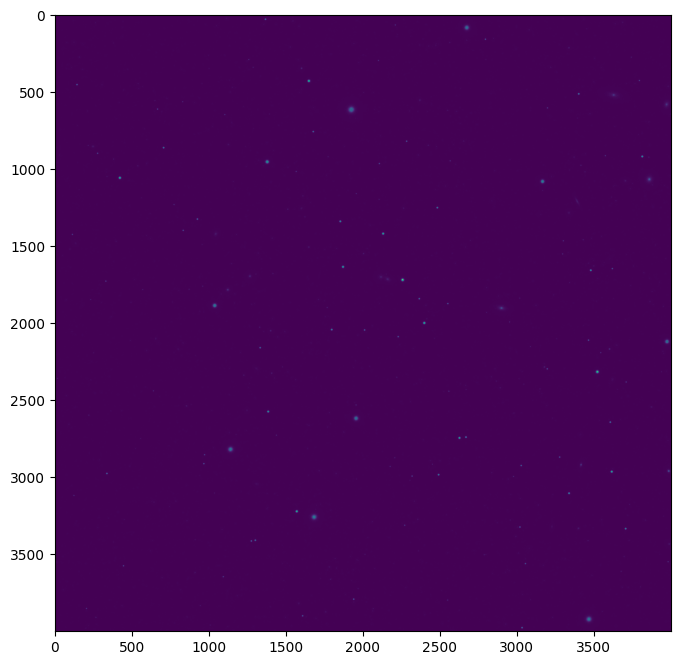

In [20]:
# full image (4000 x 4000)
fig, ax = plt.subplots(figsize=(8, 8))
image = test_sample["image"][0]
ax.imshow(np.log((image - image.min()) + 10), cmap="viridis");

### Load LSST Catalogs

In [21]:
import GCRCatalogs
GCRCatalogs.set_root_dir("/data/scratch/dc2_nfs/")
lsst_catalog = GCRCatalogs.load_catalog("desc_dc2_run2.2i_dr6_object_with_truth_match")
lsst_catalog = lsst_catalog.get_quantities(["id_truth", "objectId", 
                                            "ra", "dec", 
                                            "truth_type", 
                                            "cModelFlux_r", "cModelFluxErr_r"])
lsst_catalog = pd.DataFrame(lsst_catalog)

### Match LSST Catalog with the DC2 image

In [22]:
cur_image_wcs = test_sample["wcs"]
cur_image_true_full_catalog = test_sample["full_catalog"]
cur_image_match_id = test_sample["match_id"]

In [23]:
# filter the object in the LSST catalog and keep the object in the current dc2 image
lsst_ra = torch.tensor(lsst_catalog["ra"].values)
lsst_dec = torch.tensor(lsst_catalog["dec"].values)

lsst_pt, lsst_pr = cur_image_wcs.all_world2pix(lsst_ra, lsst_dec, 0)
lsst_pt = torch.tensor(lsst_pt)
lsst_pr = torch.tensor(lsst_pr)
lsst_plocs = torch.stack((lsst_pr, lsst_pt), dim=-1)

x0_mask = (lsst_plocs[:, 0] > 0) & (lsst_plocs[:, 0] < 4000)
x1_mask = (lsst_plocs[:, 1] > 0) & (lsst_plocs[:, 1] < 4000)
x_mask = x0_mask * x1_mask

lsst_catalog["cModelFlux"] = lsst_catalog["cModelFlux_r"] + lsst_catalog["cModelFluxErr_r"]
flux_mask = lsst_catalog["cModelFlux"] > 0

x_and_flux_mask = x_mask * torch.tensor(flux_mask.to_numpy())

lsst_catalog = lsst_catalog.loc[x_and_flux_mask.tolist()]
lsst_catalog["plocs0"] = lsst_plocs[x_and_flux_mask, 0]
lsst_catalog["plocs1"] = lsst_plocs[x_and_flux_mask, 1]

### Load the trained model and make prediction

In [24]:
# change this model path according to your training setting
MODEL_PATH = "../../output/DC2_experiments/DC2_psf_aug_asinh_06-12-1/checkpoints/best_encoder.ckpt"
encoder = instantiate(notebook_cfg.encoder)
pretrained_weights = torch.load(MODEL_PATH)["state_dict"]
encoder.load_state_dict(pretrained_weights)
encoder.eval();

In [25]:
# with open(output_dir / "plotting_model_output.pkl", "rb") as inputp: 
#     out_dict = pickle.load(inputp)

In [26]:
batch = {
    "tile_catalog": test_sample["tile_catalog"],
    "images": rearrange(test_sample["image"], "h w nw -> 1 h w nw"),
    "background": rearrange(test_sample["background"], "h w nw -> 1 h w nw"),
    "psf_params": rearrange(test_sample["psf_params"], "h w -> 1 h w")
}

with torch.no_grad():
    out_dict = encoder.predict_step(batch, None)

with open(output_dir / "plotting_model_output.pkl", "wb") as outp:  # Overwrites any existing file.
    pickle.dump(out_dict, outp, pickle.HIGHEST_PROTOCOL)

In [27]:
out_dict

{'mode_cat': TileCatalog(1 x 1000 x 1000; n_sources, locs, source_type, star_fluxes, galaxy_fluxes),
 'sample_cat': TileCatalog(1 x 1000 x 1000; n_sources, locs, source_type, star_fluxes, galaxy_fluxes)}

In [28]:
bliss_catalog = out_dict["mode_cat"]
bliss_catalog = bliss_catalog.to_full_catalog()
# bliss_catalog["plocs"] = bliss_catalog["plocs"] + 4
matcher = instantiate(notebook_cfg.encoder.matcher)
metrics = instantiate(notebook_cfg.encoder.metrics)
matching = matcher.match_catalogs(test_sample["full_catalog"], bliss_catalog)
metric = metrics(test_sample["full_catalog"], bliss_catalog, matching)
print(metric["detection_recall"], metric["detection_precision"], 
      metric["detection_f1"], metric["classification_acc"])

tensor(0.8692) tensor(0.9047) tensor(0.8866) 0.9937407374382019


### Plotting

In [29]:
# could use macher for bliss catalog and truth catalog
# this function (match_by_locs) is for matching the lsst detection location and truth object location
from einops import rearrange, reduce
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import min_weight_full_bipartite_matching
def match_by_locs(true_locs, est_locs, slack=1.0):
    """Match true and estimated locations and returned indices to match.

    Permutes `est_locs` to find minimal error between `true_locs` and `est_locs`.
    The matching is done with `scipy.optimize.linear_sum_assignment`, which implements
    the Hungarian algorithm.

    Automatically discards matches where at least one location has coordinates **exactly** (0, 0).

    Args:
        slack: Threshold for matching objects a `slack` l-infinity distance away (in pixels).
        true_locs: Tensor of shape `(n1 x 2)`, where `n1` is the true number of sources.
            The centroids should be in units of PIXELS.
        est_locs: Tensor of shape `(n2 x 2)`, where `n2` is the predicted
            number of sources. The centroids should be in units of PIXELS.

    Returns:
        A tuple of the following objects:
        - row_indx: Indicies of true objects matched to estimated objects.
        - col_indx: Indicies of estimated objects matched to true objects.
        - dist_keep: Matched objects to keep based on l1 distances.
        - avg_distance: Average l-infinity distance over all matched objects.
        - avg_keep_distance: Average l-infinity distance over matched objects to keep.
    """
    assert len(true_locs.shape) == len(est_locs.shape) == 2
    assert true_locs.shape[-1] == est_locs.shape[-1] == 2
    assert isinstance(true_locs, torch.Tensor) and isinstance(est_locs, torch.Tensor)

    # reshape
    locs1 = true_locs.view(-1, 2)
    locs2 = est_locs.view(-1, 2)

    locs_abs_diff = (rearrange(locs1, "i j -> i 1 j") - rearrange(locs2, "i j -> 1 i j")).abs()
    locs_err = reduce(locs_abs_diff, "i j k -> i j", "sum")
    locs_err_l_infty = reduce(locs_abs_diff, "i j k -> i j", "max")

    # Penalize all pairs which are greater than slack apart to favor valid matches.
    locs_err = locs_err + (locs_err_l_infty > slack) * locs_err.max()

    # add small constant to avoid 0 weights (required for sparse bipartite matching)
    locs_err += 0.001

    # convert light source error matrix to CSR
    csr_locs_err = csr_matrix(locs_err.detach().cpu())

    # find minimal permutation and return matches
    row_indx, col_indx = min_weight_full_bipartite_matching(csr_locs_err)

    # only match objects that satisfy threshold on l-infinity distance.
    dist = (locs1[row_indx] - locs2[col_indx]).abs().max(1)[0]

    # GOOD match condition: L-infinity distance is less than slack
    dist_keep = (dist < slack).bool()
    avg_distance = dist.mean()
    avg_keep_distance = dist[dist < slack].mean()

    if dist_keep.sum() > 0:
        assert dist[dist_keep].max() <= slack

    return row_indx, col_indx, dist_keep.cpu().numpy(), avg_distance, avg_keep_distance, dist


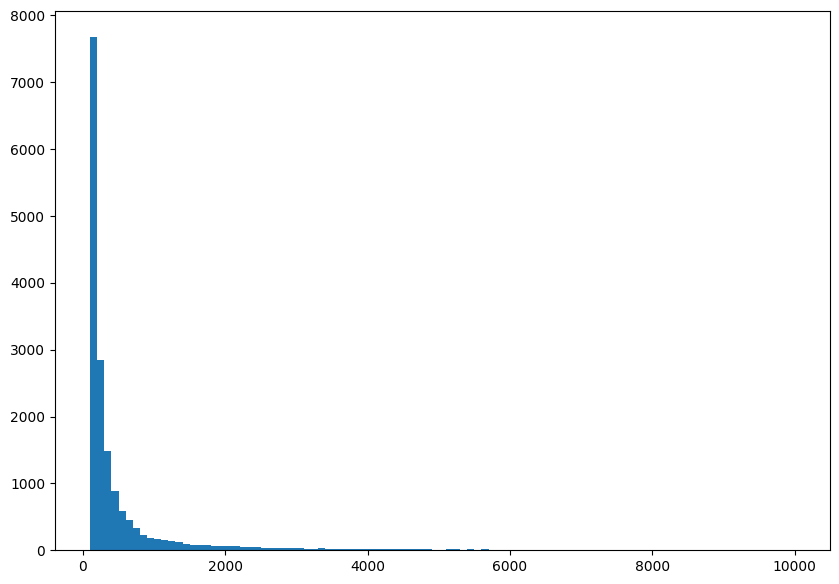

In [30]:
# galaxy flux distribution
fig, ax = plt.subplots(figsize=(10, 7))
ax.hist(cur_image_true_full_catalog["galaxy_fluxes"][0, :, 2], 
        np.linspace(100, 10000, num=100));

In [31]:
#compute detection distance
row_bliss, col_bliss, bliss_dkeep, avg_distance, avg_keep_distance, bliss_dist = match_by_locs(
    cur_image_true_full_catalog["plocs"][0], bliss_catalog["plocs"][0])
bliss_flux = bliss_catalog["galaxy_fluxes"] * bliss_catalog.galaxy_bools + \
             bliss_catalog["star_fluxes"] * bliss_catalog.star_bools
bliss_flux_dist_df = pd.DataFrame({"flux": bliss_flux[0, col_bliss, 2].numpy(), 
                                   "dist": bliss_dist.numpy()})

In [32]:
lsst_plocs = torch.stack([torch.tensor(lsst_catalog["plocs0"].to_numpy()), 
                          torch.tensor(lsst_catalog["plocs1"].to_numpy())], dim=-1)
row_lsst, col_lsst, lsst_dkeep, avg_distance, avg_keep_distance, lsst_dist = match_by_locs(
    cur_image_true_full_catalog["plocs"][0], lsst_plocs)
lsst_flux_dist_df = pd.DataFrame({"flux": lsst_catalog["cModelFlux"].to_numpy()[col_lsst], 
                                  "dist": lsst_dist.numpy()})

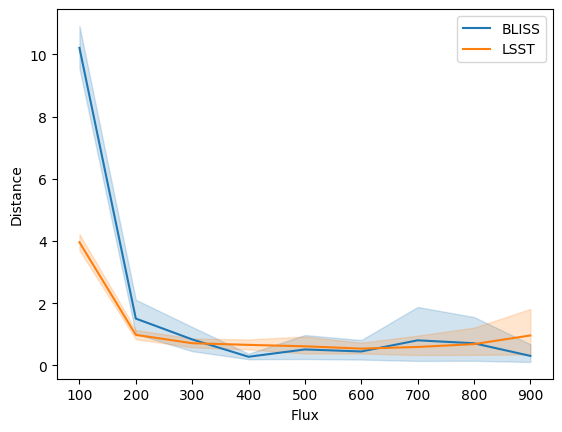

In [33]:
# Generate bin intervals
bins = np.linspace(100, 1000, num=10)
bliss_flux_dist_df["bins"] = pd.cut(bliss_flux_dist_df["flux"], bins).apply(lambda x: x.left)
lsst_flux_dist_df["bins"] = pd.cut(lsst_flux_dist_df["flux"], bins).apply(lambda x: x.left)
sns.lineplot(x=bliss_flux_dist_df["bins"], y=bliss_flux_dist_df["dist"], label="BLISS")
sns.lineplot(x=lsst_flux_dist_df["bins"], y=lsst_flux_dist_df["dist"], label="LSST")
plt.xlabel("Flux")
plt.ylabel("Distance")
plt.show()

In [34]:
metrics = {"lsst_recall": [], "bliss_recall": [], "bliss_tp": [], "lsst_tp": [], "n_true": []}

true_full_id_flux_df = pd.DataFrame({"id": cur_image_true_full_catalog["objid"][0, :, 0], 
                                     "match_id": cur_image_match_id,
                                     "flux": cur_image_true_full_catalog["galaxy_fluxes"][0, :, 2]})

true_full_id_flux_df["p0_truth"] = cur_image_true_full_catalog["plocs"][0, :, 0]
true_full_id_flux_df["p1_truth"] = cur_image_true_full_catalog["plocs"][0, :, 1]
for i, (flux_low, flux_high) in enumerate(zip(bins[:-1], bins[1:])):
    if i != len(bins) - 1:
        sub_true_full_id_flux_df = true_full_id_flux_df.loc[(true_full_id_flux_df["flux"] >= flux_low) & \
                                                            (true_full_id_flux_df["flux"] < flux_high), :]
    else:
        sub_true_full_id_flux_df = true_full_id_flux_df.loc[(true_full_id_flux_df["flux"] >= flux_low) & \
                                                            (true_full_id_flux_df["flux"] < flux_high + 1), :]
    if len(sub_true_full_id_flux_df) == 0:
        metrics["lsst_tp"].append(0)
        metrics["lsst_recall"].append(0)
        metrics["bliss_tp"].append(0)
        metrics["bliss_recall"].append(0)
        metrics["n_true"].append(0)

        continue

    n_true = len(sub_true_full_id_flux_df)
    
    p0_truth = sub_true_full_id_flux_df["p0_truth"]
    p1_truth = sub_true_full_id_flux_df["p1_truth"]
    true_plocs = torch.tensor(np.stack((p0_truth, p1_truth), axis = -1))
    
    matched_lsst = sub_true_full_id_flux_df.merge(lsst_catalog, 
                                               left_on="match_id", right_on="objectId", how="left")
    
    p0 = matched_lsst.dropna()["plocs0"]
    p1 = matched_lsst.dropna()["plocs1"]
    lsst_plocs = torch.tensor(np.stack((p0, p1), axis = -1))
    if lsst_plocs.shape[0] != 0:
        _, _, lsst_dkeep, _, _, _ = match_by_locs(true_plocs, lsst_plocs)

        lsst_tp = lsst_dkeep.sum().item()

        metrics["lsst_tp"].append(lsst_tp)
        lsst_recall = lsst_tp / n_true
        metrics["lsst_recall"].append(lsst_recall)
    else:
        metrics["lsst_tp"].append(0)
        metrics["lsst_recall"].append(0)
    
    _, _, bliss_dkeep, _, _, _ = match_by_locs(true_plocs, bliss_catalog["plocs"][0])

    bliss_tp = bliss_dkeep.sum().item()
    
    metrics["bliss_tp"].append(bliss_tp)
    bliss_recall = bliss_tp / n_true
    metrics["bliss_recall"].append(bliss_recall)
    metrics["n_true"].append(n_true)

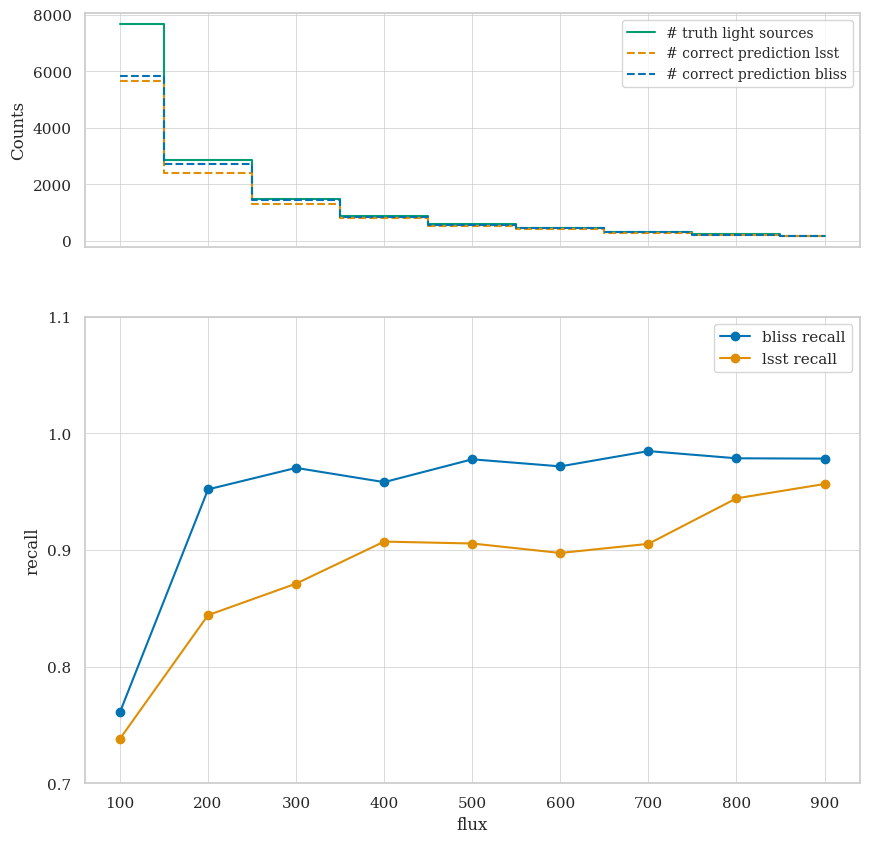

In [35]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="colorblind", font="serif")
metrics_data = pd.DataFrame(metrics, columns=["lsst_recall", "bliss_recall", 
                                              "bliss_tp", "lsst_tp", "n_true"])
ymin = metrics_data.min().min()
yticks = np.arange(np.round(ymin, 1), 1.1, 0.1)
c1, c2, c3 = plt.rcParams["axes.prop_cycle"].by_key()["color"][0:3]
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 10), gridspec_kw={"height_ratios": [1, 2]}, sharex=True
)
ax2.plot(bins[:-1], metrics_data["bliss_recall"], "-o", color=c1, label="bliss recall", markersize=6)
ax2.plot(bins[:-1], metrics_data["lsst_recall"], "-o", color=c2, label="lsst recall", markersize=6)

ax2.legend()
ax2.set_xlabel("flux")
ax2.set_ylabel("recall")
ax2.set_yticks(yticks)
ax2.grid(linestyle="-", linewidth=0.5, which="major", axis="both")

ax1.step(bins[:-1], metrics_data["n_true"], label="# truth light sources", where="mid", color=c3)
ax1.step(bins[:-1], metrics_data["lsst_tp"], label="# correct prediction lsst", ls="--", where="mid", color=c2)
ax1.step(bins[:-1], metrics_data["bliss_tp"], label="# correct prediction bliss", ls="--", where="mid", color=c1)
ymax = metrics_data.max().max()
yticks = np.round(np.linspace(0, ymax, 5), -3)
ax1.set_yticks(yticks)
ax1.set_ylabel("Counts")
ax1.legend(loc="best", prop={"size": 10})
ax1.grid(linestyle="-", linewidth=0.5, which="major", axis="both")

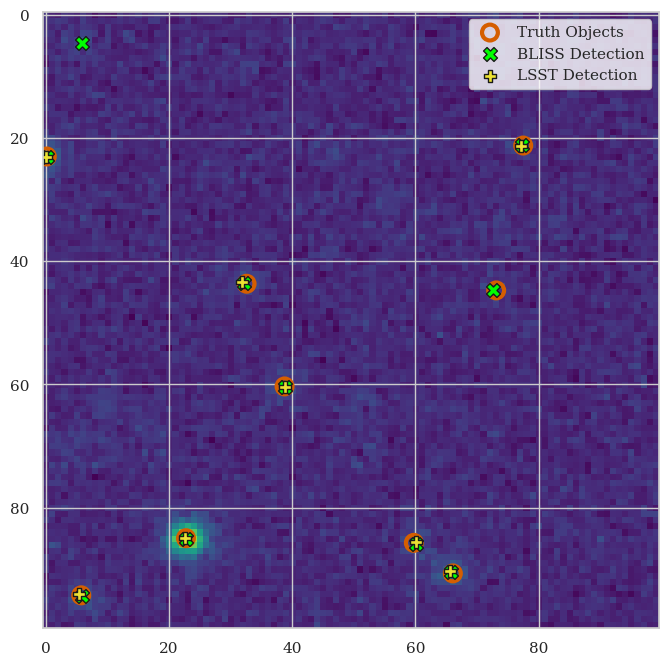

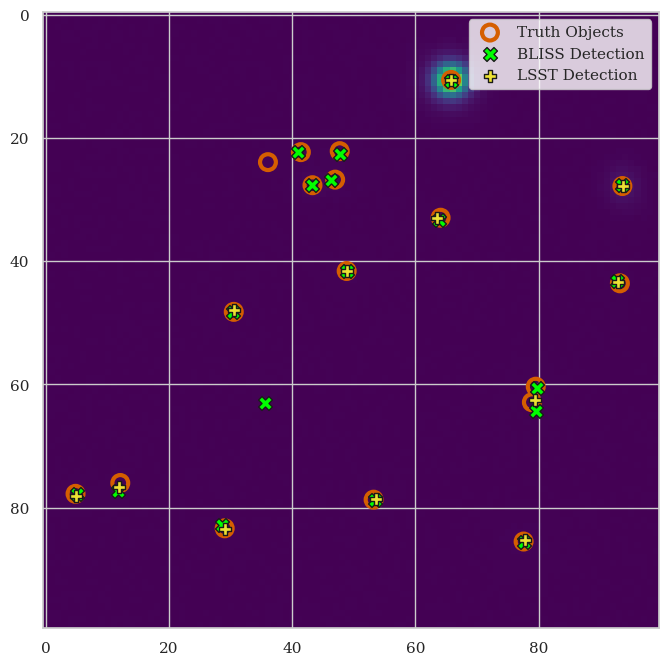

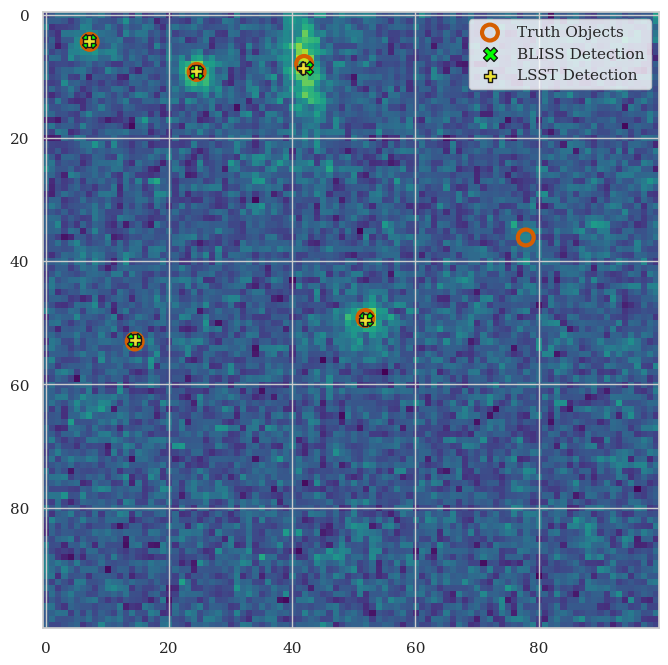

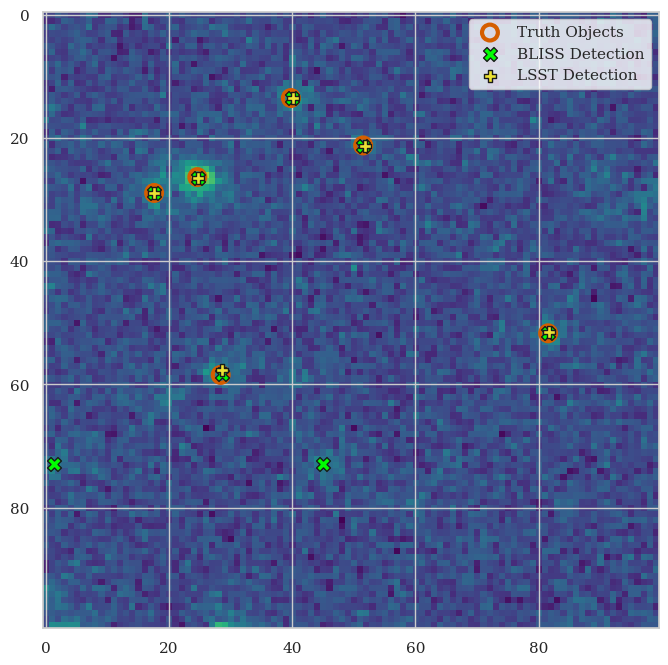

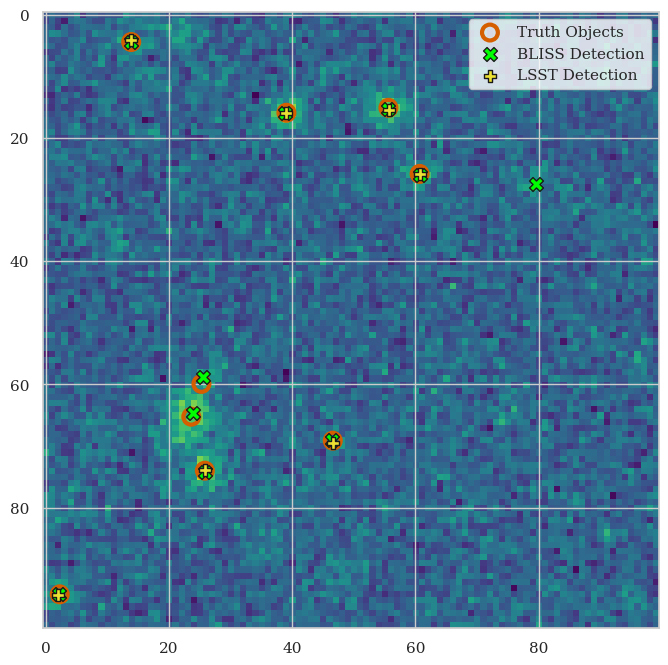

In [36]:
for i in range(5, 10):
    lim1 = i * 100
    lim2 = lim1 + 100
    true_plocs = cur_image_true_full_catalog["plocs"][0]
    x0_mask = (true_plocs[:, 0] > lim1) & (true_plocs[:, 0] < lim2)
    x1_mask = (true_plocs[:, 1] > lim1) & (true_plocs[:, 1] < lim2)
    x_mask_true = x0_mask * x1_mask

    bliss_plocs = bliss_catalog["plocs"][0]
    x0_mask = (bliss_plocs[:, 1] > lim1) & (bliss_plocs[:, 1] < lim2)
    x1_mask = (bliss_plocs[:, 0] > lim1) & (bliss_plocs[:, 0] < lim2)
    x_mask_bliss = x0_mask * x1_mask

    # run our matching algorithm (instead of using lsst's matching)
    if true_plocs[x_mask_true].shape[0] == 0:
        continue
    
    lsst_plocs = torch.stack([torch.tensor(lsst_catalog["plocs0"].to_numpy()), 
                              torch.tensor(lsst_catalog["plocs1"].to_numpy())], dim=-1)
    row_lsst, col_lsst, lsst_dkeep, avg_distance, avg_keep_distance, lsst_dist = match_by_locs(
        true_plocs[x_mask_true], lsst_plocs)
    lsst_plocs = lsst_plocs[col_lsst][lsst_dkeep]
    x0_mask = (lsst_plocs[:, 1] > lim1) & (lsst_plocs[:, 1] < lim2)
    x1_mask = (lsst_plocs[:, 0] > lim1) & (lsst_plocs[:, 0] < lim2)
    x_mask_lsst = x0_mask * x1_mask

    fig,ax = plt.subplots(figsize=(8, 8))
    image = test_sample["image"][0]
    image_small = image[lim1:lim2, lim1:lim2]
    ax.imshow(np.log((image_small - image_small.min()) + 80), cmap="viridis")
    ax.scatter(true_plocs[:, 1][x_mask_true] - lim1, true_plocs[:, 0][x_mask_true] - lim1, 
               facecolors="none", edgecolors="r", 
               alpha=1, s=130, linewidth=3, label="Truth Objects")
    ax.scatter(bliss_plocs[:, 1][x_mask_bliss] - lim1, bliss_plocs[:, 0][x_mask_bliss] - lim1, 
               marker="X", facecolors="lime", edgecolors="k", 
               alpha=1, s=100, linewidth=1, label="BLISS Detection")
    ax.scatter(lsst_plocs[:, 1][x_mask_lsst] - lim1, lsst_plocs[:, 0][x_mask_lsst] - lim1, 
               marker="P", facecolors="y", edgecolors="k", 
               alpha=1, s=80, linewidth=1, label="LSST Detection")

    ax.legend()
    plt.show()

In [38]:
# Galaxy error plots
true_matches, bliss_matches = matching[0]
# true_galaxy_params = cur_image_true_full_catalog["galaxy_params"][0, true_matches, :]
# bliss_galaxy_params = bliss_catalog["galaxy_params"][0, bliss_matches, :]
# galaxy_params_err = true_galaxy_params - bliss_galaxy_params
# err_df = pd.DataFrame({
#                     "flux": cur_image_true_full_catalog["galaxy_fluxes"][0, true_matches, :][:, 2],
#                     "disk_frac":galaxy_params_err[:, 0],
#                     "beta_radians":galaxy_params_err[:, 1],
#                     "disk_q":galaxy_params_err[:, 2],
#                     "a_d":galaxy_params_err[:, 3],
#                     "bulge_q":galaxy_params_err[:, 4],
#                     "a_b":galaxy_params_err[:, 5]})

In [39]:
# err_df["bins"] = pd.cut(err_df["flux"], bins).apply(lambda x: x.left)
# sns.lineplot(x=err_df["bins"], y=abs(err_df["beta_radians"]), label="BLISS")
# plt.xlabel("Flux")
# plt.ylabel("beta_radians")
# plt.show()

In [40]:
# err_df["bins"] = pd.cut(err_df["flux"], bins).apply(lambda x: x.left)
# sns.lineplot(x=err_df["bins"], y=abs(err_df["a_d"]), label = "BLISS")
# plt.xlabel("Flux")
# plt.ylabel("a_d")
# plt.show()

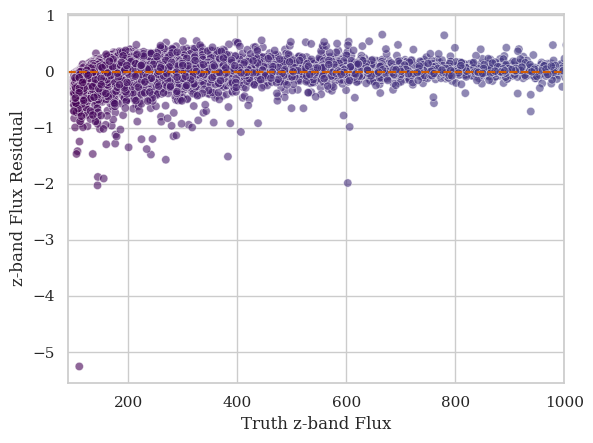

In [41]:
# flux error
true_flux = cur_image_true_full_catalog.on_fluxes[0, true_matches, :]
bliss_flux = bliss_catalog.on_fluxes[0, bliss_matches, :]
flux_err = true_flux - bliss_flux
est_band_flux = bliss_flux[:, 2]
true_band_flux = true_flux[:, 2]
res = flux_err[:, 2] / true_band_flux
sns.scatterplot(
    x = np.array(true_band_flux), 
    y = np.array(res), 
    alpha = 0.6,
    c = np.log(true_flux[:, 2]), 
    cmap = "viridis"
)
plt.xlim(90, 1000)
plt.ylabel('z-band Flux Residual')
plt.xlabel('Truth z-band Flux')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()